In [1]:
# Imports
# be sure to install numpy, scipy, matplotlib, corner and *pymultinest* (os is standard)
# if one of these is missing, you'll get an error here
# *IMPORTANT*: install pymultinest using the following line in your terminal:
# conda install -c conda-forge/label/cf201901 pymultinest
# if you install multinest using pip install, you might get some error like
# AttributeError: dlsym(RTLD_DEFAULT, run): symbol not found
# in the block where you run multinest; the standard pip install doesn't properly connect pymultinest to an underlying multinest installation
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import corner
import pymultinest as multinest
import os

In [2]:
# Define functions
def delta_function(c, m):
    """
    Compute delta, the decay constant
    """
    return c/2/m

def omega0_function(k, m):
    """
    Compute omega_0, the oscillation frequency for the undamped oscillator
    """
    return k/m
    
def underdamped_pos(t, m, A, phi, c, k):
    """
    Compute the underdamped position at the time array t, throws an error
    if the input produces a critically damped or overdamped oscillator
    """
    delta = delta_function(c, m)
    omega0 = omega0_function(k, m)
    if delta >= omega0:
        raise ValueError('System is not underdamped. Damper is too strong.')
    omega = np.sqrt(omega0**2 - delta**2)
    return np.exp(-delta*t)*A*np.cos(omega*t+phi)

def underdamped_envelope(t, m, A, c):
    """
    Compute the underdamped positive envelope at the time array t
    """
    delta = delta_function(c, m)
    return A*np.exp(-delta*t)

In [3]:
# Injection 

# set time and mass, the fixed known quantities
t = np.linspace(0, 19, 20) # time array for data
t_fine = np.linspace(0, 19, 1000) # fine time array for plot
m = 3

# set allowed ranges for other parameters
# param order = A, phi, c, k
min_params = np.array([1, 0, 0.5, 1])
max_params = np.array([5, 2*np.pi, 2, 5])
# to make it underdamped, half of the max c should be less than the min k 
# (equal is fine because the max is never achieved)

# generate the true parameters, comment out the first line and uncomment the second in order
# to use the parameters used in the talk
# true_params = np.random.uniform(low=min_params, high=max_params)
true_params = np.array([3.87150364, 4.08570741, 1.09783054, 3.10030603]) # explicitly use the parameters from the talk
true_A, true_phi, true_c, true_k = true_params # unpack array of injected parameters

# create signal from the (true) injected parameters
signal = underdamped_pos(t, m, true_A, true_phi, true_c, true_k)
signal_fine = underdamped_pos(t_fine, m, true_A, true_phi, true_c, true_k)
pos_env_fine = underdamped_envelope(t_fine, m, true_A, true_c)
neg_env_fine = -underdamped_envelope(t_fine, m, true_A, true_c)

# add gaussian noise to signal to simulate error
errors = np.full(20, 0.1)
noise = np.random.normal(loc=0.0, scale=errors)
data = signal + noise

In [4]:
# see the true parameters
print(true_params)

[3.87150364 4.08570741 1.09783054 3.10030603]


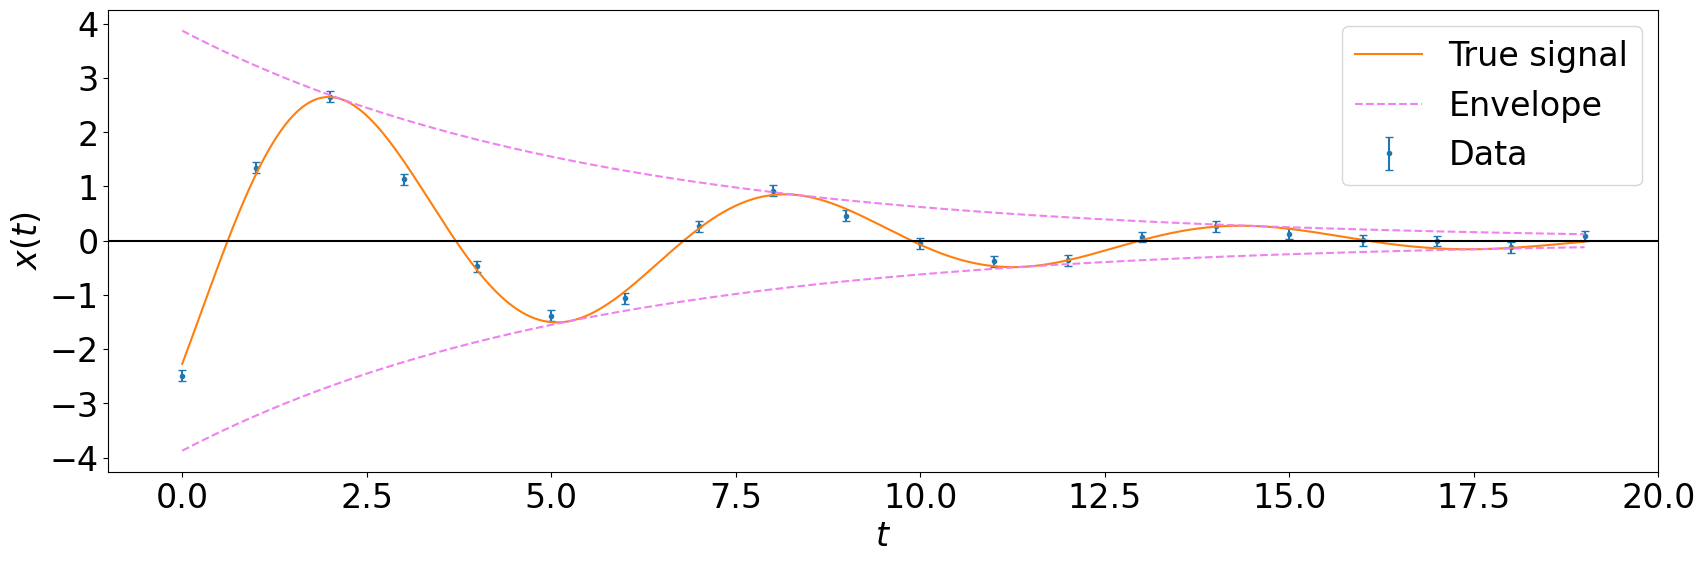

In [5]:
# Plot the data and the true signal
%matplotlib inline

fontsize=24

plt.figure(figsize = (20,6))
plt.errorbar(t, data, yerr=errors, barsabove=True, capsize=3.0, fmt='.', label = 'Data')
plt.plot(t_fine, signal_fine, label = 'True signal')
plt.plot(t_fine, pos_env_fine, label = 'Envelope', color='violet', linestyle='dashed')
plt.plot(t_fine, neg_env_fine, color='violet', linestyle='dashed')
plt.plot(np.linspace(-1, 20, 22), np.zeros(22), color='k')
plt.xlabel(r'$t$', fontsize = fontsize)
plt.ylabel(r'$x(t)$', fontsize = fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim(-1, 20)
plt.legend(prop={'size': fontsize})
plt.show()

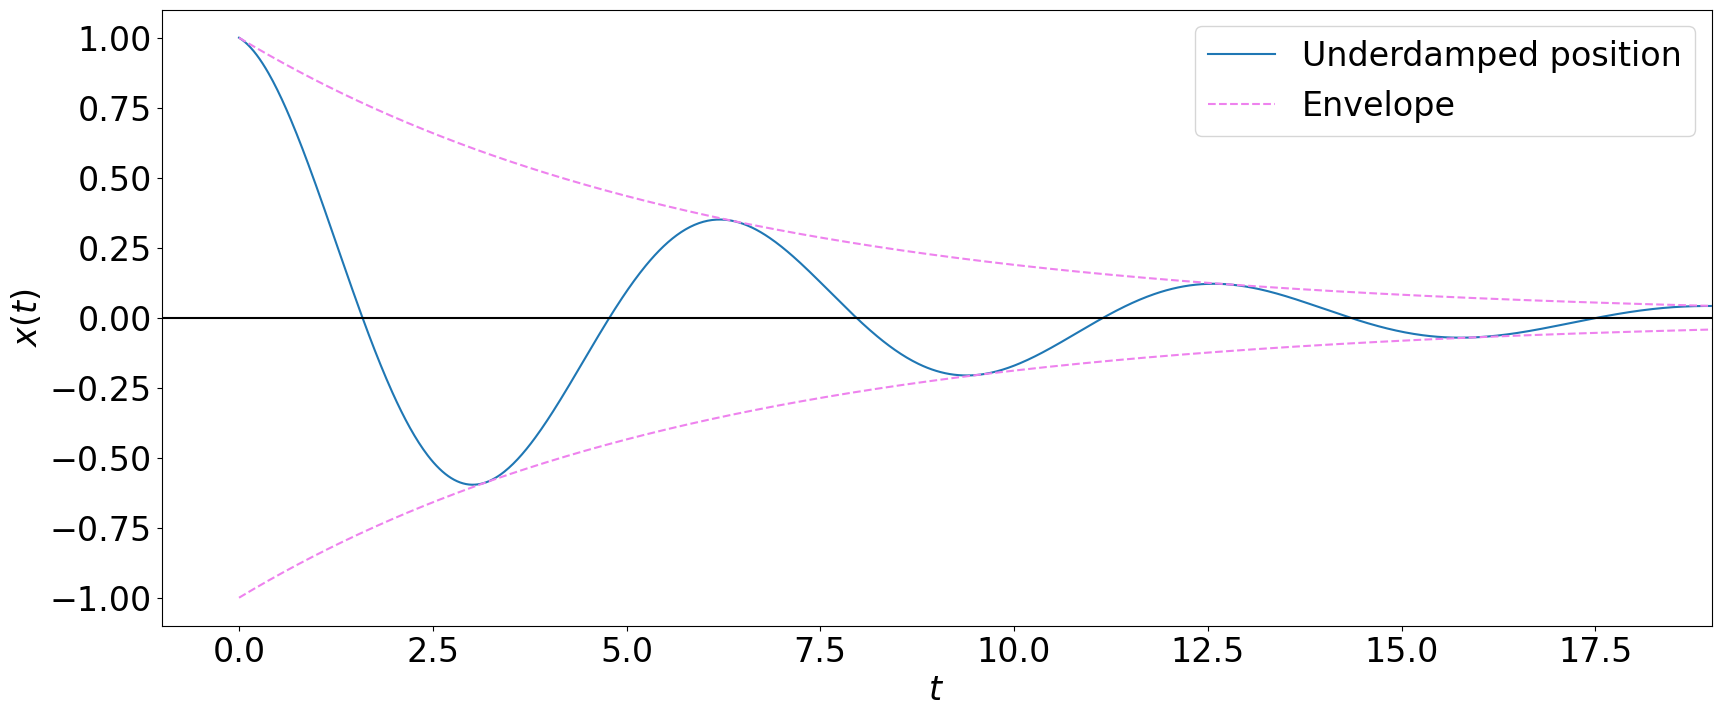

In [6]:
# Plot another set of parameters
%matplotlib inline
plt.figure(figsize = (20,8))
# plt.errorbar(t, data, yerr=errors, barsabove=True, capsize=3.0, fmt='.', label = 'data')
ex_A = 1
ex_phi = 0
ex_c = 1
ex_k = 3

ex_signal_fine = underdamped_pos(t_fine, m, ex_A, ex_phi, ex_c, ex_k)
ex_pos_env_fine = underdamped_envelope(t_fine, m, ex_A, ex_c)
ex_neg_env_fine = -underdamped_envelope(t_fine, m, ex_A, ex_c)

fontsize=24

plt.plot(t_fine, ex_signal_fine, label = 'Underdamped position')
plt.plot(t_fine, ex_pos_env_fine, label = 'Envelope', color='violet', linestyle='dashed')
plt.plot(t_fine, ex_neg_env_fine, color='violet', linestyle='dashed')
plt.plot(np.linspace(-1, 20, 22), np.zeros(22), color='k')
plt.xlabel(r'$t$', fontsize = fontsize)
plt.ylabel(r'$x(t)$', fontsize = fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim(-1, 19)
plt.legend(prop={'size': fontsize})
plt.show()

In [7]:
# define the natural logarithm of the likelihood, MultiNest uses this
def loglike(params, t, m, data, error):
    """
    Compute the log likelihood function
    This is required by MultiNest
    """
    model = underdamped_pos(t, m, *params)
    return -1/2*np.sum(((data-model)/error)**2)

In [8]:
# run this to get an estimate of the runtime of one likelihood evaluation
%timeit loglike(true_params, t, m, data, errors)

6.65 µs ± 40 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
# Below define a few functions that will be used to launch pyMultiNest runs
def logprior(params):
    """
    Compute the log prior function
    This is required by MultiNest
    """
    return 0.0 # ln 1 = 0

def multinest_logposterior(cube, ndim, nparams):
    """
    Compute the log posterior function
    This is required by MultiNest
    """
    lp = logprior(cube)
    params = cube[:ndim]
    lnL = loglike(params, t, m, data, errors)
    return lp + lnL

bounds = np.transpose([min_params, max_params])
def multinest_rescale(cube, ndim, nparams):
    """
    Rescale a hypercube to the physical parameter space
    This is required by MultiNest
    """
    for i in range(ndim):
        cube[i] = bounds[i][0] + (bounds[i][1]-bounds[i][0]) * cube[i]
    return

def run_multinest(outdir, ndim=4, verbose=False, nlive=400, etol=0.5, wrapped_params=None):
    """
    Run MultiNest, and save the result in the directory 'outdir'
    """
    # make the output directory if it doesn't yet exist
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    # run multinest
    multinest.run(LogLikelihood=multinest_logposterior, Prior=multinest_rescale, n_dims=ndim,  \
              outputfiles_basename=outdir+'/', verbose=verbose,  \
              n_live_points=nlive, evidence_tolerance=etol,  \
              wrapped_params=wrapped_params, resume=True, n_iter_before_update=10)
    print('MULTINEST HAS FINISHED!!!')
    return

In [10]:
# create the directory for multinest runs if it doesn't already exist
if not os.path.exists('multinest_runs'):
    os.mkdir('multinest_runs')
run_num = 0
# # ===========================================================================
# # Uncomment this bit to save previous folders and put results in a new folder
# if os.path.exists('multinest_runs/run'+str(run_num)):
#     run_num += 1
# # ===========================================================================

In [11]:
# run multinest and compute the posterior, which is stored in the multinest_runs subdirectory

# this line runs pymultinest, wrapped params are the ones in which we assume wrap around boundary conditions, we do this for phi (there is a 1 in that index) as phi=0 and phi=2*pi are identified
%time run_multinest('multinest_runs/run_'+str(run_num), wrapped_params = [0,1,0,0])

AttributeError: dlsym(RTLD_DEFAULT, run): symbol not found

In [12]:
# generate the corner plot of the posterior
%matplotlib inline
pos_run_num = 0 # pick a run number
# extract the posterior from the directory in which it's saved
posterior = np.loadtxt('multinest_runs/run_'+str(pos_run_num)+'/post_equal_weights.dat', usecols=range(4))

labels = ['A', r'$\phi$', 'c', 'k']
ranges = [(min_params[i], max_params[i]) for i in range(4)]

# create the corner plot, levels describe the contours (1 sigma, 2 sigma, 3 sigma inclusion)
fig = corner.corner(posterior, levels=[0.6827, 0.9545, 0.9973], truths=true_params, plot_datapoints = False, plot_density=False, labels = labels, color='black', normed = True, smooth=1.0, range=ranges)
# make the labels bigger
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize='x-large')
fig.show()

FileNotFoundError: multinest_runs/run_0/post_equal_weights.dat not found.

In [13]:
# print number of samples
print('Number of samples:', posterior.shape[0])

Number of samples: 1893


In [15]:
# compare the true parameters with the parameters that produce the best log likelihood (and also posterior, as prior is constant)

# best likelihood
best_params = posterior[-1]
print('Comparison of true parameters and best found parameters:')
print('\n')
print('A:')
print('True: '+str(true_params[0])+'  Best: '+str(best_params[0]))
print('\n')
print('phi:')
print('True: '+str(true_params[1])+'  Best: '+str(best_params[1]))
print('\n')
print('c:')
print('True: '+str(true_params[2])+'  Best: '+str(best_params[2]))
print('\n')
print('k:')
print('True: '+str(true_params[3])+'  Best: '+str(best_params[3]))
print('\n')
print('Log likelihood of true solution:', loglike(true_params, t, m, data, errors))
print('Best found log likelihood:', loglike(best_params, t, m, data, errors))

best_signal_fine = underdamped_pos(t_fine, m, *best_params)

Comparison of true parameters and best found parameters:


A:
True: 3.87150364  Best: 3.713579762099793


phi:
True: 4.08570741  Best: 4.102690383945427


b:
True: 1.09783054  Best: 1.0729254196506677


k:
True: 3.10030603  Best: 3.0844684680113126


Log likelihood of true solution: -8.654078350749279
Best found log likelihood: -7.29334449989012


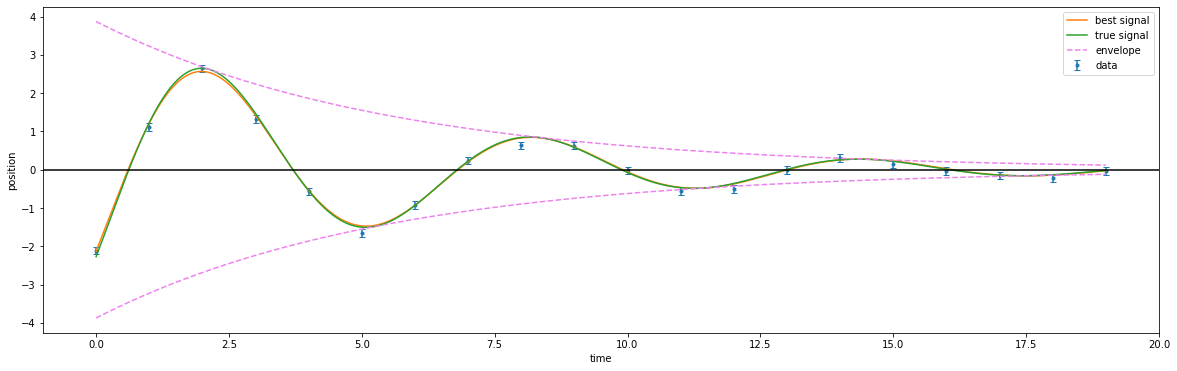

In [16]:
# Compare the model from the best parameters with the model from the true parameters
%matplotlib inline
plt.figure(figsize = (20,6))
plt.errorbar(t, data, yerr=errors, barsabove=True, capsize=3.0, fmt='.', label = 'data')
plt.plot(t_fine, best_signal_fine, label = 'best signal')
plt.plot(t_fine, signal_fine, label = 'true signal')
plt.plot(t_fine, pos_env_fine, label = 'envelope', color='violet', linestyle='dashed')
plt.plot(t_fine, neg_env_fine, color='violet', linestyle='dashed')

plt.plot(np.linspace(-1, 20, 22), np.zeros(22), color='k')
plt.xlabel('time')
plt.ylabel('position')
plt.xlim(-1, 20)
plt.legend()
plt.show()